In [1]:
from supervised_utils import *
import warnings as wrngs

In [2]:
wrngs.filterwarnings('ignore', category=RuntimeWarning)

### Task di regressione su `score`

#### Addestramento e tuning sul dataset originale `movies_v2.csv`

In [3]:
df = pd.read_csv('../dataset/movies_v2.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'year', 'score', 'votes', 'budget', 'gross', 'runtime']

cols = {
    'target': 'score',
    'drop': list(df.columns.difference(cols_to_retain)),
    'dummies': ['rating', 'genre'],
    'labels': [],
    'round': [],
    'clipping': ['votes', 'budget', 'gross'],
    'standardize': ['runtime'],
    'minmax': ['year', 'votes', 'budget', 'gross']
}

--------------------------------------------------------------------------------

Training and tuning [Ridge_Regressor]...

Results after GridSearchCV:
Best parameters: {'alpha': 2}
Best score: {'mean_squared_error': 0.5112}


Test score for [Ridge_Regressor]:
MSE: 0.5044
MAE: 0.5315



--------------------------------------------------------------------------------

Training and tuning [Decision_Tree_Regressor]...

Results after GridSearchCV:
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15}
Best score: {'mean_squared_error': 0.5554}

Results after max_depth tuning:
Best parameters: {'max_depth': 8}
Best score: {'mean_squared_error': 0.5373}



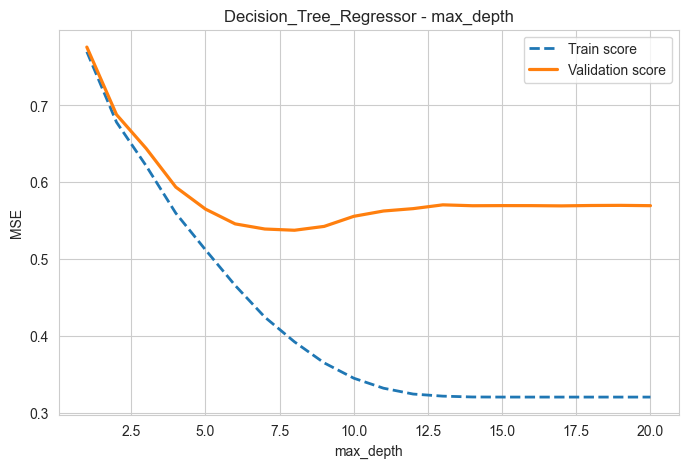


Test score for [Decision_Tree_Regressor]:
MSE: 0.5207
MAE: 0.5307



--------------------------------------------------------------------------------

Training and tuning [Random_Forest_Regressor]...

Results after GridSearchCV:
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 250}
Best score: {'mean_squared_error': 0.4368}

Results after max_depth tuning:
Best parameters: {'max_depth': 24}
Best score: {'mean_squared_error': 0.4364}



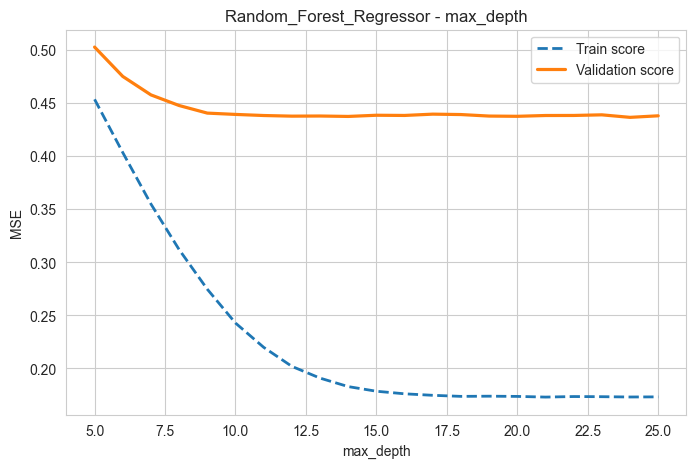

Results after n_estimators tuning:
Best parameters: {'n_estimators': 250}
Best score: {'mean_squared_error': 0.4369}



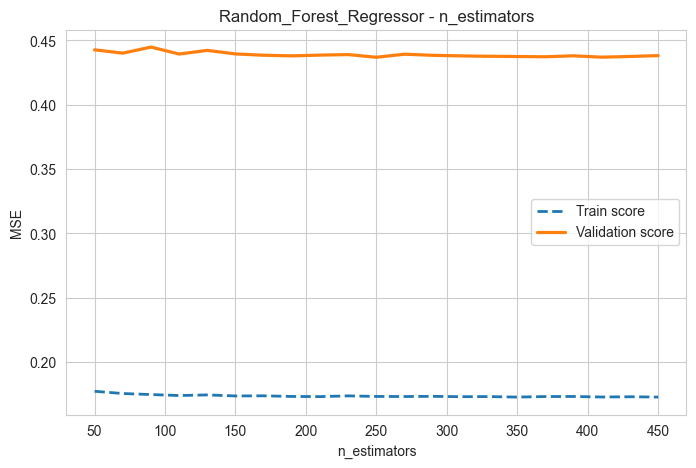


Test score for [Random_Forest_Regressor]:
MSE: 0.4040
MAE: 0.4668



--------------------------------------------------------------------------------

Training and tuning [Gradient_Boosting_Regressor]...

Results after GridSearchCV:
Best parameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 500}
Best score: {'mean_squared_error': 0.4122}

Results after max_depth tuning:
Best parameters: {'max_depth': 7}
Best score: {'mean_squared_error': 0.4122}



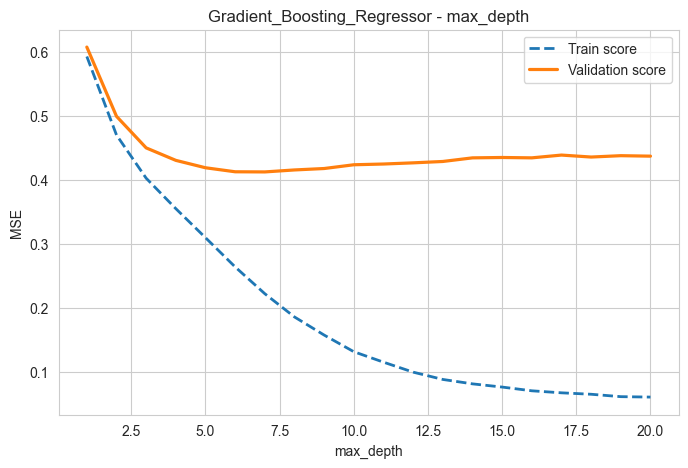

Results after n_estimators tuning:
Best parameters: {'n_estimators': 340}
Best score: {'mean_squared_error': 0.4332}



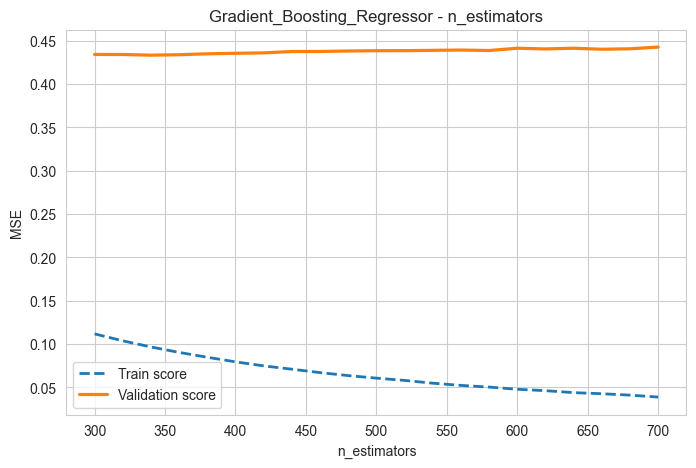


Test score for [Gradient_Boosting_Regressor]:
MSE: 0.4139
MAE: 0.4769





In [4]:
# tuning e testing dei modelli
tune_and_test_models_for_regression(df, cols, session_name='original')

#### Addestramento e tuning sul primo dataset derivato `movies_not_binned.csv`

In [5]:
df = pd.read_csv('../dataset/movies_not_binned.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'score', 'profit', 'cultness', 'age', 'runtime', 'votes', 'budget', 'gross',
                  'director_num_movies', 'director_age', 'director_profit_mean', 'director_profit_std', 'director_score_mean', 'director_score_std',
                  'actor_num_movies', 'actor_age', 'actor_profit_mean', 'actor_profit_std', 'actor_score_mean', 'actor_score_std']

cols = {
    'target': 'score',
    'drop': list(df.columns.difference(cols_to_retain)),
    'dummies': ['rating', 'genre'],
    'labels': [],
    'round': [],
    'clipping': ['profit', 'votes', 'budget', 'gross',
                 'director_profit_mean', 'actor_profit_mean',
                 'director_profit_std', 'actor_profit_std'],
    'standardize': ['runtime', 'cultness', 'director_age', 'actor_age'],
    'minmax': ['age', 'profit', 'votes', 'budget', 'gross',
               'director_num_movies', 'actor_num_movies',
               'director_profit_mean', 'actor_profit_mean',
               'director_profit_std', 'actor_profit_std',
               'director_score_mean', 'actor_score_mean',
               'director_score_std', 'actor_score_std']
}

--------------------------------------------------------------------------------

Training and tuning [Ridge_Regressor]...

Results after GridSearchCV:
Best parameters: {'alpha': 1}
Best score: {'mean_squared_error': 0.0991}


Test score for [Ridge_Regressor]:
MSE: 0.0992
MAE: 0.2415



--------------------------------------------------------------------------------

Training and tuning [Decision_Tree_Regressor]...

Results after GridSearchCV:
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score: {'mean_squared_error': 0.0148}

Results after max_depth tuning:
Best parameters: {'max_depth': 19}
Best score: {'mean_squared_error': 0.0147}



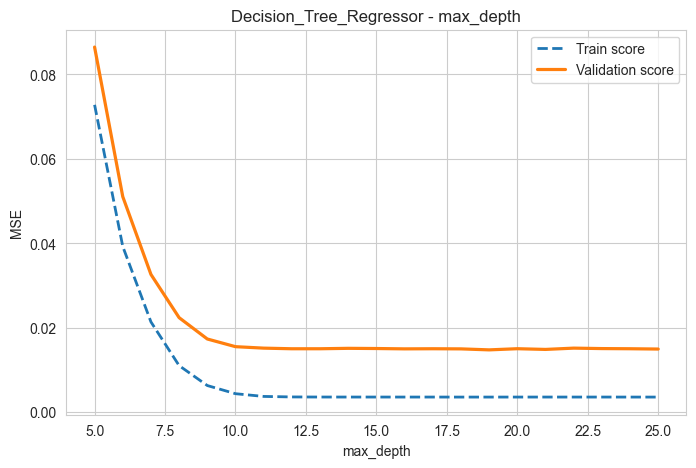


Test score for [Decision_Tree_Regressor]:
MSE: 0.0145
MAE: 0.0596



--------------------------------------------------------------------------------

Training and tuning [Random_Forest_Regressor]...

Results after GridSearchCV:
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best score: {'mean_squared_error': 0.0065}

Results after max_depth tuning:
Best parameters: {'max_depth': 20}
Best score: {'mean_squared_error': 0.0065}



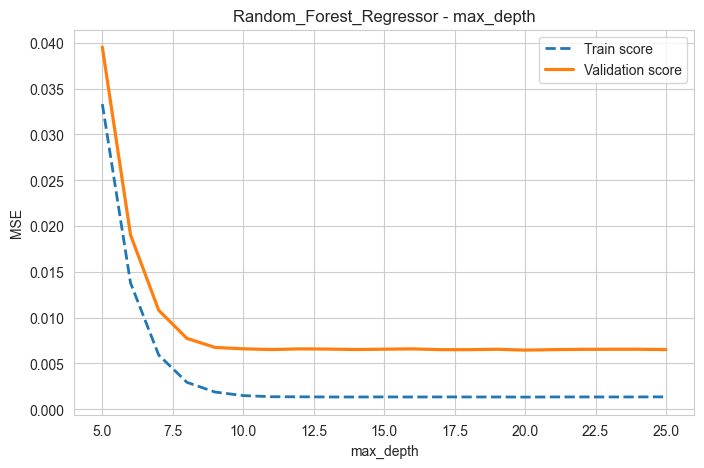

Results after n_estimators tuning:
Best parameters: {'n_estimators': 680}
Best score: {'mean_squared_error': 0.0065}



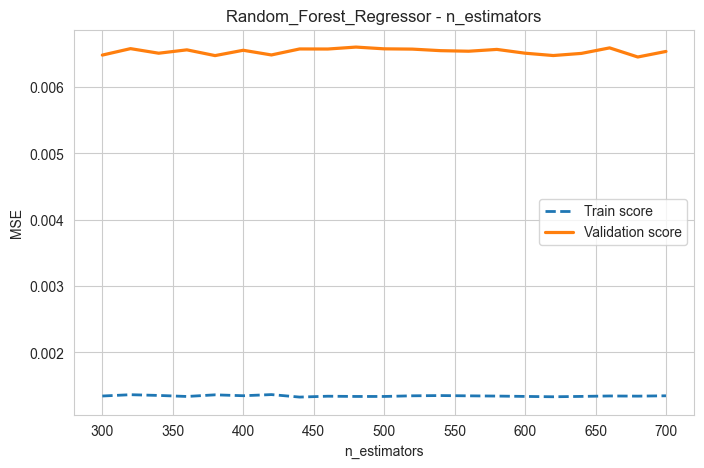


Test score for [Random_Forest_Regressor]:
MSE: 0.0064
MAE: 0.0326



--------------------------------------------------------------------------------

Training and tuning [Gradient_Boosting_Regressor]...

Results after GridSearchCV:
Best parameters: {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best score: {'mean_squared_error': 0.0050}

Results after max_depth tuning:
Best parameters: {'max_depth': 5}
Best score: {'mean_squared_error': 0.0049}



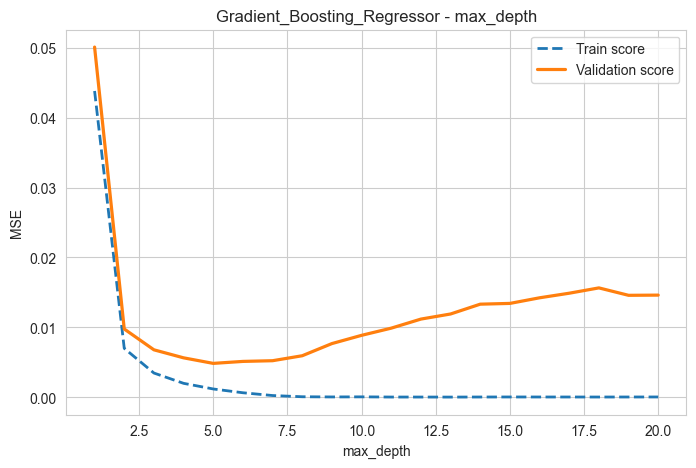

KeyboardInterrupt: 

In [6]:
# tuning e testing dei modelli
tune_and_test_models_for_regression(df, cols, session_name='not_binned')

#### Addestramento e tuning sul secondo dataset derivato `movies_binned.csv`

In [ ]:
df = pd.read_csv('../dataset/movies_binned.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'score', 'profitability', 'cultness', 'age', 'runtime', 'votes', 'budget', 'gross',
                  'director_num_movies', 'director_age', 'director_profit_mean', 'director_profit_std', 'director_score_mean', 'director_score_std',
                  'actor_num_movies', 'actor_age', 'actor_profit_mean', 'actor_profit_std', 'actor_score_mean', 'actor_score_std']

cols = {
    'target': 'score',
    'drop': list(df.columns.difference(cols_to_retain)),
    'dummies': ['rating', 'genre', 'profitability', 'cultness', 'age', 'runtime',
                'votes', 'budget', 'gross', 'director_age', 'actor_age',
                'director_num_movies', 'actor_num_movies',
                'director_profit_mean', 'actor_profit_mean',
                'director_profit_std', 'actor_profit_std',
                'director_score_mean', 'actor_score_mean',
                'director_score_std', 'actor_score_std'],
    'labels': [],
    'round': [],
    'clipping': [],
    'standardize': [],
    'minmax': []
}

In [ ]:
# tuning e testing dei modelli
tune_and_test_models_for_regression(df, cols, session_name='binned')

### Task di classificazione su `profitability`

#### Addestramento e tuning sul primo dataset derivato `movies_not_binned.csv`

#### Addestramento e tuning sul secondo dataset derivato `movies_binned.csv`